In [1]:
#imports and Drive mounting
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import os

# fix random seed for reproducibility
seed = 2020
np.random.seed(seed)  

from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

TensorFlow 2.x selected.
2.1.0


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def plot_history(history):
  plt.figure(figsize = (12,4))
  plt.subplot(1,2,1)

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['accuracy']),'g-',
           label='Train accuracy')
  plt.plot(history.epoch, np.array(history.history['val_accuracy']),'r-',
           label = 'Validation accuracy')
  plt.ylim([0.0,1.0])
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss minimised by model')
  plt.plot(history.epoch, np.array(history.history['loss']),'g-',
           label='Train loss')
  plt.plot(history.epoch, np.array(history.history['val_loss']),'r-',
           label = 'Validation loss')
  plt.legend()

In [4]:
# Load the data: CIFAR100 with 20 class labels
(x_train_all, r_train_all_class), ( _ , _ ) = cifar100.load_data(label_mode='coarse')

num_classes = 20

val_size = 6000
# make validation set
x_train, x_val, r_train_class, r_val_class = train_test_split(x_train_all, r_train_all_class, test_size=val_size, random_state=0)

# let's again take a subset of the training data first, for playing around
# Note that such a subset is only useful if it can guide your tuning process,
# i.e., if it leads you to similar decisions as you would make on the whole training set

# In this case, 10000 samples is really too small: you can check this by comparing the validation curves 
# for 10000 training samples with those for all training samples. 
# The validation accuracy should not be very different!

x_train_small = x_train[:20000]
r_train_small_class = r_train_class[:20000]

# And we do the same standardization as in the first assignment
x_train_all = x_train_all.astype('float32')
x_train = x_train.astype('float32')
x_train_small = x_train_small.astype('float32')
x_val = x_val.astype('float32')

x_train_all /= 255.0
x_train /= 255.0
x_train_small /= 255.0
x_val /= 255.0

# the labels from the downloaded data are integer numbers
# for a multi-class classification task, we again convert each integer
# to a vector with 19 zeros and a single '1', corresponding to the right class
r_train_all = tf.keras.utils.to_categorical(r_train_all_class, num_classes)
r_train = tf.keras.utils.to_categorical(r_train_class, num_classes)
r_train_small = tf.keras.utils.to_categorical(r_train_small_class, num_classes)
r_val = tf.keras.utils.to_categorical(r_val_class, num_classes)


# Labels
labels = [
'aquatic mammals',
'fish',
'flowers',
'food containers',
'fruit and vegetables',
'household electrical devices',
'household furniture',
'insects',
'large carnivores',
'large man-made outdoor things',
'large natural outdoor scenes',
'large omnivores and herbivores',
'medium-sized mammals',
'non-insect invertebrates',
'people',
'reptiles',
'small mammals',
'trees',
'vehicles 1',
'vehicles 2'
]

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')

169009152/169001437 [==============================] - 6s 0us/step
x_train shape: (44000, 32, 32, 3)
44000 train samples
6000 validation samples


In [0]:
# First, make the model more complex to lower bias

def complex_model(nb_conv=0,nb_dense=0):
  model = Sequential()

  # Convolutional layers
  model.add(Conv2D(64, (3, 3), padding='same',input_shape=x_train.shape[1:]))
  model.add(BatchNormalization(
    axis=-1, momentum=0.95, epsilon=0.001, center=True, scale=True,
    beta_initializer='zeros', gamma_initializer='ones',
    moving_mean_initializer='zeros', moving_variance_initializer='ones',
    beta_regularizer=None, gamma_regularizer=None, beta_constraint=None,
    gamma_constraint=None, renorm=False, renorm_clipping=None, renorm_momentum=0.95,
    fused=None, trainable=True, virtual_batch_size=None, adjustment=None, name=None,
  ))
  model.add(Activation('relu'))

  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(BatchNormalization(
    axis=-1, momentum=0.95, epsilon=0.001, center=True, scale=True,
    beta_initializer='zeros', gamma_initializer='ones',
    moving_mean_initializer='zeros', moving_variance_initializer='ones',
    beta_regularizer=None, gamma_regularizer=None, beta_constraint=None,
    gamma_constraint=None, renorm=False, renorm_clipping=None, renorm_momentum=0.95,
    fused=None, trainable=True, virtual_batch_size=None, adjustment=None, name=None,
  ))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Activation('relu'))

  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(BatchNormalization(
    axis=-1, momentum=0.95, epsilon=0.001, center=True, scale=True,
    beta_initializer='zeros', gamma_initializer='ones',
    moving_mean_initializer='zeros', moving_variance_initializer='ones',
    beta_regularizer=None, gamma_regularizer=None, beta_constraint=None,
    gamma_constraint=None, renorm=False, renorm_clipping=None, renorm_momentum=0.95,
    fused=None, trainable=True, virtual_batch_size=None, adjustment=None, name=None,
  ))
  model.add(Activation('relu'))

  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(BatchNormalization(
    axis=-1, momentum=0.95, epsilon=0.001, center=True, scale=True,
    beta_initializer='zeros', gamma_initializer='ones',
    moving_mean_initializer='zeros', moving_variance_initializer='ones',
    beta_regularizer=None, gamma_regularizer=None, beta_constraint=None,
    gamma_constraint=None, renorm=False, renorm_clipping=None, renorm_momentum=0.95,
    fused=None, trainable=True, virtual_batch_size=None, adjustment=None, name=None,
  ))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Activation('relu'))
  
  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(BatchNormalization(
    axis=-1, momentum=0.95, epsilon=0.001, center=True, scale=True,
    beta_initializer='zeros', gamma_initializer='ones',
    moving_mean_initializer='zeros', moving_variance_initializer='ones',
    beta_regularizer=None, gamma_regularizer=None, beta_constraint=None,
    gamma_constraint=None, renorm=False, renorm_clipping=None, renorm_momentum=0.95,
    fused=None, trainable=True, virtual_batch_size=None, adjustment=None, name=None,
  ))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Activation('relu'))

  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(BatchNormalization(
    axis=-1, momentum=0.95, epsilon=0.001, center=True, scale=True,
    beta_initializer='zeros', gamma_initializer='ones',
    moving_mean_initializer='zeros', moving_variance_initializer='ones',
    beta_regularizer=None, gamma_regularizer=None, beta_constraint=None,
    gamma_constraint=None, renorm=False, renorm_clipping=None, renorm_momentum=0.95,
    fused=None, trainable=True, virtual_batch_size=None, adjustment=None, name=None,
  ))
  model.add(Activation('relu'))

  model.add(Conv2D(128, (1,1), padding='same'))
  model.add(BatchNormalization(
    axis=-1, momentum=0.95, epsilon=0.001, center=True, scale=True,
    beta_initializer='zeros', gamma_initializer='ones',
    moving_mean_initializer='zeros', moving_variance_initializer='ones',
    beta_regularizer=None, gamma_regularizer=None, beta_constraint=None,
    gamma_constraint=None, renorm=False, renorm_clipping=None, renorm_momentum=0.95,
    fused=None, trainable=True, virtual_batch_size=None, adjustment=None, name=None,
  ))
  model.add(Activation('relu'))

  model.add(Conv2D(128, (1,1), padding='same'))
  model.add(BatchNormalization(
    axis=-1, momentum=0.95, epsilon=0.001, center=True, scale=True,
    beta_initializer='zeros', gamma_initializer='ones',
    moving_mean_initializer='zeros', moving_variance_initializer='ones',
    beta_regularizer=None, gamma_regularizer=None, beta_constraint=None,
    gamma_constraint=None, renorm=False, renorm_clipping=None, renorm_momentum=0.95,
    fused=None, trainable=True, virtual_batch_size=None, adjustment=None, name=None,
  ))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Activation('relu'))

  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  # end of convolutional layers, start of 'hidden' dense layers (can be more than 1 if necessary)
  model.add(Flatten())
  #model.add(Dense(512))
  #model.add(Activation('relu'))

  # Final dense layer = linear classifier
  #model.add(Dropout(0.1))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  opt = tf.keras.optimizers.Adam() #using defaults for now

  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

  return model

In [10]:
model = complex_model()
model.summary()

batch_size = 1024
epochs = 500
es_callback = EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.0001)

history = model.fit(x_train, r_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks = [es_callback],
          validation_data=(x_val, r_val),
          shuffle=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
activation_14 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 128)      

Training set Accuracy:   1.00
Training set Loss: 0.0010

Validation set Accuracy:   0.67
Validation set Loss: 1.9151



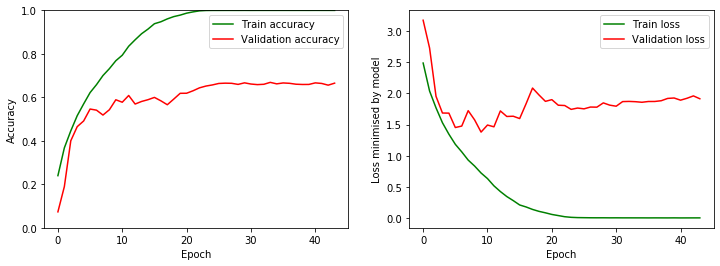

In [11]:
# We analyse the result:

[train_loss, train_accuracy] = model.evaluate(x_train_small, r_train_small, verbose=0)
print("Training set Accuracy:{:7.2f}".format(train_accuracy))
print("Training set Loss:{:7.4f}\n".format(train_loss))

[val_loss, val_accuracy] = model.evaluate(x_val, r_val, verbose=0)
print("Validation set Accuracy:{:7.2f}".format(val_accuracy))
print("Validation set Loss:{:7.4f}\n".format(val_loss))

#Now we visualise what happened during training
plot_history(history)

In [0]:
model = complex_model()
es_callback = EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.0001)

datagen = ImageDataGenerator(
    featurewise_center=True, samplewise_center=True,
    featurewise_std_normalization=True, samplewise_std_normalization=True,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=45, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=True,
    vertical_flip=True, rescale=None, preprocessing_function=None,
    data_format=None, validation_split=0.0, dtype=None
)

datagen.fit(x_train,augment=True)

au_history = model.fit(datagen.flow(
    x_train, r_train, batch_size=batch_size, shuffle=True, sample_weight=None, seed=None,
    save_to_dir=None, save_prefix='', save_format='png', subset=None),
    epochs=epochs, steps_per_epoch=len(x_train) / batch_size,
                                    validation_data=(x_val, r_val),
                                    callbacks = [es_callback])

# We analyse the result:

[train_loss, train_accuracy] = model.evaluate(x_train_small, r_train_small, verbose=0)
print("Training set Accuracy:{:7.2f}".format(train_accuracy))
print("Training set Loss:{:7.4f}\n".format(train_loss))

[val_loss, val_accuracy] = model.evaluate(x_val, r_val, verbose=0)
print("Validation set Accuracy:{:7.2f}".format(val_accuracy))
print("Validation set Loss:{:7.4f}\n".format(val_loss))

#Now we visualise what happened during training
plot_history(au_history)

  ...
    to  
  ['...']
Train for 42.96875 steps, validate on 6000 samples
Epoch 1/500
43/42 [==============================] - 30s 708ms/step - loss: 2.7358 - accuracy: 0.1812 - val_loss: 5.9902 - val_accuracy: 0.0528
Epoch 2/500
43/42 [==============================] - 30s 695ms/step - loss: 2.3671 - accuracy: 0.2706 - val_loss: 9.7465 - val_accuracy: 0.0528
Epoch 3/500
43/42 [==============================] - 30s 688ms/step - loss: 2.1967 - accuracy: 0.3181 - val_loss: 8.3169 - val_accuracy: 0.0528
Epoch 4/500
43/42 [==============================] - 30s 691ms/step - loss: 2.0536 - accuracy: 0.3572 - val_loss: 11.1019 - val_accuracy: 0.0528
Epoch 5/500
43/42 [==============================] - 30s 688ms/step - loss: 1.9529 - accuracy: 0.3882 - val_loss: 8.4486 - val_accuracy: 0.0528
Epoch 6/500
43/42 [==============================] - 30s 691ms/step - loss: 1.8312 - accuracy: 0.4238 - val_loss: 7.3995 - val_accuracy: 0.0528
Epoch 7/500
43/42 [==============================] - 29s 68

In [0]:
def plot_dual_history(before,after):
  plt.figure(figsize = (20,6))
  plt.subplot(1,2,1)

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(before.epoch, np.array(before.history['accuracy']),'g-',
           label='Initial train accuracy')
  plt.plot(after.epoch, np.array(after.history['accuracy']),'g:',
           label='Final train accuracy')
  plt.plot(before.epoch, np.array(before.history['val_accuracy']),'r-',
           label = 'Initial validation accuracy')
  plt.plot(after.epoch, np.array(after.history['val_accuracy']),'r:',
           label = 'Final validation accuracy')
  plt.ylim([0.0,1.0])
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss minimised by model')
  plt.plot(before.epoch, np.array(before.history['loss']),'g-',
           label='Initial train loss')
  plt.plot(after.epoch, np.array(after.history['loss']),'g:',
           label='Final train loss')
  plt.plot(before.epoch, np.array(before.history['val_loss']),'r-',
           label = 'Initial validation loss')
  plt.plot(after.epoch, np.array(after.history['val_loss']),'r:',
           label = 'Final validation loss')
  plt.legend()


plot_dual_history(history,au_history)

In [0]:
# Grid search number of conv and dense blocks
conv_blocks = range(1,6)
dense_blocks = range(1,6)
accuracies = [[]]
losses = [[]]

for nb_conv in conv_blocks:
  conv_acc = [[]]
  conv_loss = [[]]
  for nb_dense in dense_blocks:
    model = complex_model(nb_conv,nb_dense)
    model.fit(x_train, r_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, r_val),
          shuffle=True)
    [val_loss, val_accuracy] = model.evaluate(x_val, r_val, verbose=0)
    conv_acc = np.append(conv_acc,[[val_accuracy]],axis=1)
    conv_loss = np.append(conv_loss,[[val_loss]],axis=1)
  accuracies = np.append(accuracies,conv_acc)
  losses = np.append(losses,conv_loss)

index_acc = np.unravel_index(np.argmax(accuracies, axis=None), accuracies.shape)
index_loss = np.unravel_index(np.argmin(losses,axis=None), losses.shape)
best_acc = accuracies[index_acc]
best_loss = losses[index_loss]

print(f'Best acc of {best_acc} for {index_acc}')
print(f'Best loss of {best_loss} for {index_loss}')

Train on 44000 samples, validate on 6000 samples
Epoch 1/50
44000/44000 [==============================] - 3s 73us/sample - loss: 2.8782 - accuracy: 0.0896 - val_loss: 2.6880 - val_accuracy: 0.1482
Epoch 2/50
44000/44000 [==============================] - 3s 58us/sample - loss: 2.5911 - accuracy: 0.1821 - val_loss: 2.4853 - val_accuracy: 0.2170
Epoch 3/50
44000/44000 [==============================] - 3s 57us/sample - loss: 2.4083 - accuracy: 0.2473 - val_loss: 2.3255 - val_accuracy: 0.2705
Epoch 4/50
44000/44000 [==============================] - 3s 59us/sample - loss: 2.2530 - accuracy: 0.2976 - val_loss: 2.1618 - val_accuracy: 0.3162
Epoch 5/50
44000/44000 [==============================] - 3s 58us/sample - loss: 2.1100 - accuracy: 0.3379 - val_loss: 2.1009 - val_accuracy: 0.3352
Epoch 6/50
44000/44000 [==============================] - 3s 57us/sample - loss: 2.0048 - accuracy: 0.3715 - val_loss: 1.9401 - val_accuracy: 0.3858
Epoch 7/50
44000/44000 [==============================] -

Train on 44000 samples, validate on 6000 samples
Epoch 1/10
44000/44000 [==============================] - 4s 89us/sample - loss: 2.8835 - accuracy: 0.0996 - val_loss: 2.6683 - val_accuracy: 0.1707
Epoch 2/10
44000/44000 [==============================] - 3s 73us/sample - loss: 2.5911 - accuracy: 0.1943 - val_loss: 2.4712 - val_accuracy: 0.2260
Epoch 3/10
44000/44000 [==============================] - 3s 75us/sample - loss: 2.3842 - accuracy: 0.2585 - val_loss: 2.2875 - val_accuracy: 0.2905
Epoch 4/10
44000/44000 [==============================] - 3s 73us/sample - loss: 2.2342 - accuracy: 0.3041 - val_loss: 2.1765 - val_accuracy: 0.3287
Epoch 5/10
44000/44000 [==============================] - 3s 74us/sample - loss: 2.1169 - accuracy: 0.3437 - val_loss: 2.0842 - val_accuracy: 0.3500
Epoch 6/10
44000/44000 [==============================] - 3s 74us/sample - loss: 1.9877 - accuracy: 0.3803 - val_loss: 1.9666 - val_accuracy: 0.3838
Epoch 7/10
44000/44000 [==============================] -

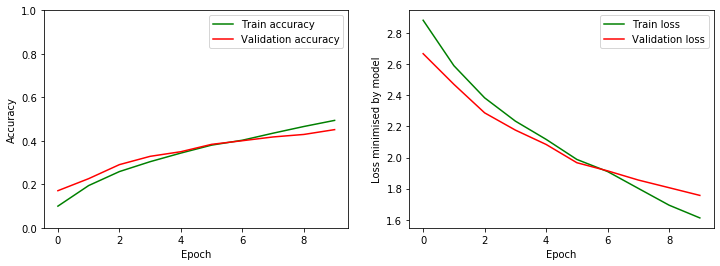

In [0]:
history = model.fit(x_train, r_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, r_val),
#          callbacks = [cp_callback, stopping_callback],
          shuffle=True)

# We analyse the result:

[train_loss, train_accuracy] = model.evaluate(x_train_small, r_train_small, verbose=0)
print("Training set Accuracy:{:7.2f}".format(train_accuracy))
print("Training set Loss:{:7.4f}\n".format(train_loss))

[val_loss, val_accuracy] = model.evaluate(x_val, r_val, verbose=0)
print("Validation set Accuracy:{:7.2f}".format(val_accuracy))
print("Validation set Loss:{:7.4f}\n".format(val_loss))

#Now we visualise what happened during training
plot_history(history)